In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
data = pd.read_csv('credit_train.csv', header = 0, sep = ';')
data.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,48,MAR,UMN,"59998,00",10,1.6,"0,770249",GRD,������������� ����,30000.0,1.0,1.0,0
1,2,F,28,MAR,UMN,"10889,00",6,1.1,"0,248514",GRD,������,43000.0,2.0,0.0,0
2,3,M,32,MAR,SPC,"10728,00",12,1.1,"0,459589",SCH,��� �����������,23000.0,5.0,0.0,0
3,4,F,27,DIV,SPC,"12009,09",12,1.1,"0,362536",GRD,��� �������������,17000.0,2.0,0.0,0
4,5,M,45,MAR,SPC,"16908,89",10,1.1,"0,421385",SCH,����������� �������,25000.0,1.0,0.0,0


In [3]:
X = data.drop(['open_account_flg', 'client_id'], 1)
y = data['open_account_flg']

In [5]:
numeric_cols = ['age', 'credit_sum', 'credit_month', 'tariff_id', 'score_shk', 
                            'monthly_income', 'credit_count', 'overdue_credit_count']
categorical_cols = list(set(X.columns.values.tolist()) - set(numeric_cols))

In [6]:
# Преобразование в строки категориальных признаков и заполнение пропущенных значений
X_cat = data[categorical_cols].fillna('NA').astype(str)

# Декодирование 'living_region'  в unicode
temp=[]
map(lambda x: temp.append(x.decode('cp1251')),X_cat['living_region'])
X_cat['living_region'] = temp

In [7]:
# Приведение строк к числам в 'credit_sum'
temp = []
map(lambda x: temp.append(float(x.replace(',', '.'))), data['credit_sum'])
data['credit_sum'] = temp

# Приведение строк к числам в 'score_shk'
temp = []
map(lambda x: temp.append(float(x.replace(',', '.'))), data['score_shk'])
data['score_shk'] = temp

In [8]:
# Вычисление средних
def calculate_means(numeric_data):
    means = np.zeros(numeric_data.shape[1])
    for j in range(numeric_data.shape[1]):
        to_sum = numeric_data.iloc[:,j]
        indices = np.nonzero(~numeric_data.iloc[:,j].isnull())[0]
        correction = np.amax(to_sum[indices])
        to_sum /= correction
        for i in indices:
            means[j] += to_sum[i]
        means[j] /= indices.size
        means[j] *= correction
    return pd.Series(means, numeric_data.columns)

In [8]:
# Заполнение нулями пропущенных значений
X_real_zeros = data[numeric_cols]
X_real_zeros = X_real_zeros.fillna(0)

In [9]:
# Заполнение средними пропущенных значений
X_real_mean = data[numeric_cols]
means = calculate_means(data[numeric_cols])
for col, mean in zip(numeric_cols, means):
    X_real_mean[col] = X_real_mean[col].fillna(mean)

C:\Users\Ivan\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Преобразование категориальных признаков и формирование выборок

In [9]:
from sklearn.feature_extraction import DictVectorizer as DV
encoder = DV(sparse = False)
encoder.fit(X_cat.T.to_dict().values())
X_cat_oh = encoder.transform(X_cat.T.to_dict().values()) # one-hot encoding

In [15]:
X_zeros = np.hstack((X_real_zeros, X_cat_oh))
X_means = np.hstack((X_real_mean, X_cat_oh))

# Тренировочные выборки
X_train_zeros = X_zeros[:10000]
X_train_means = X_means[:10000]

# Тестовые выборки
X_test_zeros = X_zeros[10000:15000]
X_test_means = X_means[10000:15000]

In [32]:
y_train = y[:10000]
y_test = y[10000:15000]

### Логистическая регрессия

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score

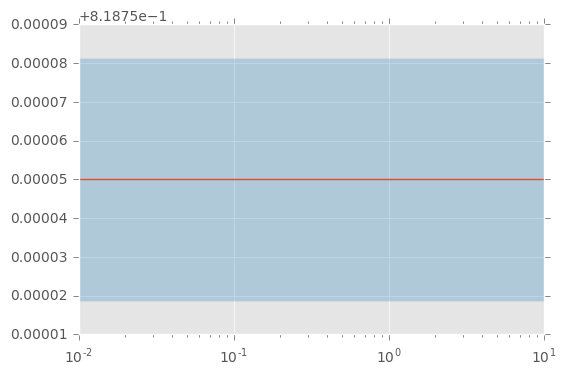

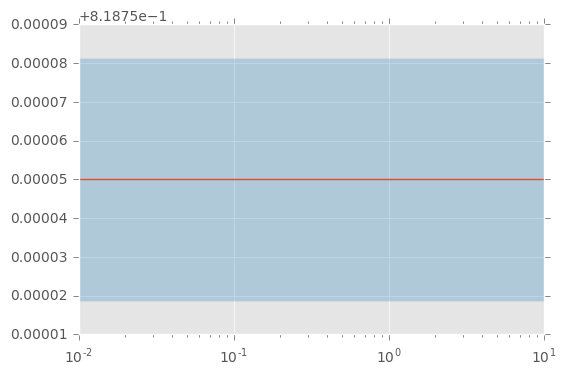

In [28]:
def plot_scores(optimizer):
    scores = [[item[0]['C'], 
               item[1], 
               (np.sum((item[2]-item[1])**2)/(item[2].size-1))**0.5] for item in optimizer.grid_scores_]
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()
    
def write_answer_1(auc_1, auc_2):
    auc = (auc_1 + auc_2)/2
    with open("preprocessing_lr_answer1.txt", "w") as fout:
        fout.write(str(auc))
        
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3


# Логистическая регрессия
estimator = LogisticRegression()

# Кросс-валидация на двух выборках
optimizer_zeros = GridSearchCV(estimator, param_grid, cv = 3)
optimizer_mean = GridSearchCV(estimator, param_grid, cv = 3)
optimizer_zeros.fit(X_train_zeros, y_train)
optimizer_mean.fit(X_train_means, y_train)

# Построение графиков оценок точности
plot_scores(optimizer_zeros)
plot_scores(optimizer_mean)

In [30]:
from sklearn import metrics

In [33]:
# Предсказания модели на тестовой выборке
predictions_zeros = optimizer_zeros.best_estimator_.predict_proba(X_test_zeros)
predictions_mean = optimizer_mean.best_estimator_.predict_proba(X_test_means)

# Метрика AUC ROC для двух выборок
auc_1 = metrics.roc_auc_score(y_test, predictions_zeros[:,1])
auc_2 = metrics.roc_auc_score(y_test, predictions_mean[:,1])
print "Метрика AUC ROC при заполнении пустых полей нулями: {}".format(auc_1)
print "Метрика AUC ROC при заполнении пустых полей средними значениями: {}".format(auc_2)

Метрика AUC ROC при заполнении пустых полей нулями: 0.558911357241
Метрика AUC ROC при заполнении пустых полей средними значениями: 0.55881815491


### Случайный лес

In [36]:
from sklearn import ensemble, cross_validation

In [38]:
scores = []
for n in [5, 8, 15, 40, 50]:
    rf_classifier = ensemble.RandomForestClassifier(n_estimators = 100, max_features = n, random_state = 1)
    scores.append(cross_validation.cross_val_score(rf_classifier, X_train_zeros, y_train, cv = 10).mean())

In [39]:
scores

[0.82020062770062763,
 0.8197012279012279,
 0.82020132780132771,
 0.82140212840212834,
 0.82040082770082756]

In [42]:
rf_classifier = ensemble.RandomForestClassifier(n_estimators = 100, max_depth = 50, max_features = 40, random_state = 1)

In [52]:
rf_classifier.fit(X_train_zeros, y_train)
predictions_zeros = rf_classifier.predict(X_test_zeros)
auc1 = metrics.roc_auc_score(y_test, predictions_zeros)

rf_classifier.fit(X_train_means, y_train)
predictions_means = rf_classifier.predict(X_test_means)
auc2 = metrics.roc_auc_score(y_test, predictions_means)

print auc1, '\n', auc2

0.52362340158 
0.529478202517


## Масштабирование вещественных признаков

In [11]:
from sklearn.preprocessing import StandardScaler

In [49]:
# Масшатабирование выборок
scaler = StandardScaler().fit(X_real_zeros[:10000])
X_train_real_scaled = scaler.transform(X_real_zeros[:10000])
X_test_real_scaled = scaler.transform(X_real_zeros[10000:15000])

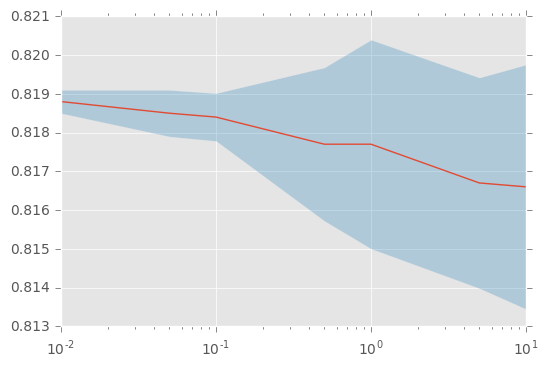

{'C': 0.01}

In [58]:
# Масштабированные выборки
X_train_scaled = np.hstack((X_train_real_scaled, X_cat_oh[:10000]))
X_test_scaled = np.hstack((X_test_real_scaled, X_cat_oh[10000:15000]))

# Логистическая регрессия
estimator = LogisticRegression()

# Кросс-валидация
optimizer = GridSearchCV(estimator, param_grid, cv = 3)
optimizer.fit(X_train_scaled, y_train)

# Построение графика оценки точности
plot_scores(optimizer)

# Гиперпараметр
optimizer.best_params_

In [59]:
# Предсказания модели на тестовой выборке
predictions = optimizer.best_estimator_.predict_proba(X_test_scaled)

# Метрика AUC ROC после масштабирования
auc = metrics.roc_auc_score(y_test, predictions[:,1])
print "Метрика AUC ROC после масштабирования: {}".format(auc)

Метрика AUC ROC после масштабирования: 0.657465054775


## Балансировка классов

In [60]:
print(np.sum(y_train==0))
print(np.sum(y_train==1))

8188
1812


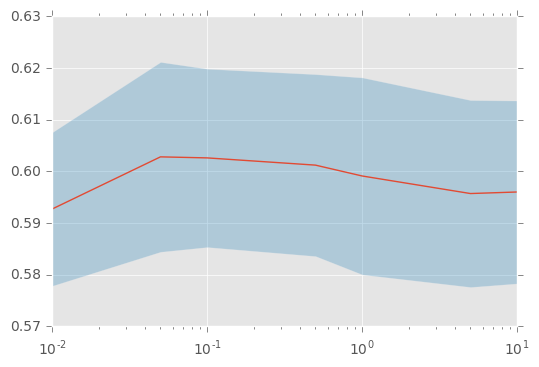

{'C': 0.05}

In [61]:
# Логистическая регрессия c использованием весов
estimator_weighted = LogisticRegression(class_weight='balanced' )

# Кросс-валидация
optimizer_weighted = GridSearchCV(estimator_weighted, param_grid, cv = 3)
optimizer_weighted.fit(X_train_scaled, y_train)

# Построение графика оценки точности
plot_scores(optimizer_weighted)

# Гиперпараметр
optimizer_weighted.best_params_

In [62]:
# Предсказания модели на тестовой выборке
predictions_weighted = optimizer_weighted.best_estimator_.predict_proba(X_test_scaled)

# Метрика AUC ROC при балансировке весами
auc_1 = metrics.roc_auc_score(y_test, predictions_weighted[:,1])
print "Метрика AUC ROC при балансировке весами: {}".format(auc_1)

Метрика AUC ROC при балансировке весами: 0.661535454731


## Трансформация вещественных признаков

In [43]:
from sklearn.preprocessing import PolynomialFeatures

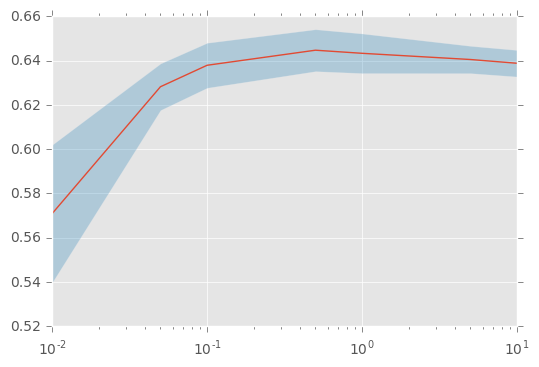

{'C': 0.5}

In [92]:
# Инициализируем класс, который выполняет преобразование
transform = PolynomialFeatures(3)

# Обучаем преобразование на обучающей выборке, применяем его к тестовой (Для вещественных признаков)
X_train_real_poly = transform.fit_transform(X_train_real_scaled)
X_test_real_poly = transform.transform(X_test_real_scaled)

# Целевая переменная
y_train_poly = y_train
y_test_poly = y_test

# Масшатабирование
scaler = StandardScaler().fit(X_train_real_poly)
X_train_real_poly = scaler.transform(X_train_real_poly)
X_test_real_poly = scaler.transform(X_test_real_poly)

# Обучающая и тестовая выборки
X_train_poly = np.hstack((X_train_real_poly, X_cat_oh[:10000]))
X_test_poly = np.hstack((X_test_real_poly, X_cat_oh[10000:15000]))

# Логистическая регрессия c использованием весов
estimator_poly = LogisticRegression(class_weight='balanced')

# Кросс-валидация
optimizer_poly = GridSearchCV(estimator_poly, param_grid, cv = 3)
optimizer_poly.fit(X_train_poly, y_train_poly)

# Построение графика оценки точности
plot_scores(optimizer_poly)

# Гиперпараметр
optimizer_poly.best_params_

In [93]:
# Предсказания модели на тестовой выборке
predictions_poly = optimizer_poly.best_estimator_.predict_proba(X_test_poly)

# Метрика AUC ROC после квадратичного преобразования
auc_poly = metrics.roc_auc_score(y_test_poly, predictions_poly[:,1])
print "Метрика AUC ROC после квадратичного преобразования: {}".format(auc_poly)

Метрика AUC ROC после квадратичного преобразования: 0.692312558816


Наилучший результат получен при обучении логистической регрессии с L2-регуляризацией (параметр регуляризации $С = 0.05$)  на выборке, у которой пропущенные вещественные значения заполнены нулями, вещественные признаки отмасштабированы, а также трансформированы полиномиально до 3 степени.

## Непосредственно задача

### Обучающая выборка

In [12]:
# Масштабирование вещественных признаков
scaler = StandardScaler().fit(X_real_zeros)
X_train_real_scaled = scaler.transform(X_real_zeros)

In [25]:
X_train_cat_oh = X_cat_oh
y_train = y

### Тестовая выборка

In [28]:
data_test = pd.read_csv('credit_test.csv', header = 0, sep = ';')
data_test.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count
0,170747,F,48,MAR,UMN,"16558,00",10,1.10,"0,370409",GRD,������� ����,34000,2.0,0.0
1,170748,M,29,MAR,SPC,"7028,72",6,1.40,"0,377281",SCH,��� �����������,19000,3.0,0.0
2,170749,F,20,UNM,SPC,"13019,00",10,1.60,"0,538515",SCH,��� ������������,25000,1.0,0.0
3,170750,F,41,MAR,SPC,"9379,00",10,1.10,"0,482520",GRD,��� ���������,30000,0.0,0.0
4,170751,F,31,MAR,SPC,"13990,00",6,1.43,"0,485914",GRD,��� ���������,20000,2.0,0.0


In [29]:
data_test.shape

(91940, 14)

In [31]:
X_test = data_test.drop(['client_id'], 1)

In [32]:
X_test.shape

(91940, 13)

In [33]:
numeric_cols = ['age', 'credit_sum', 'credit_month', 'tariff_id', 'score_shk', 
                            'monthly_income', 'credit_count', 'overdue_credit_count']
categorical_cols = list(set(X.columns.values.tolist()) - set(numeric_cols))

In [34]:
# Преобразование в строки категориальных признаков и заполнение пропущенных значений
X_test_cat = data_test[categorical_cols].fillna('NA').astype(str)

# Декодирование 'living_region'  в unicode
temp=[]
map(lambda x: temp.append(x.decode('cp1251')),X_test_cat['living_region'])
X_test_cat['living_region'] = temp

In [35]:
# Приведение строк к числам в 'credit_sum'
temp = []
map(lambda x: temp.append(float(x.replace(',', '.'))), data_test['credit_sum'])
data_test['credit_sum'] = temp

# Приведение строк к числам в 'score_shk'
temp = []
map(lambda x: temp.append(float(x.replace(',', '.'))), data_test['score_shk'])
data_test['score_shk'] = temp

In [36]:
# Заполнение нулями пропущенных значений
X_test_real_zeros = data_test[numeric_cols]
X_test_real_zeros = X_test_real_zeros.fillna(0)

In [38]:
# Преобразование категориальных признаков
X_test_cat_oh = encoder.transform(X_test_cat.T.to_dict().values()) # one-hot encoding

### Масштабирование вещественных признаков

In [39]:
X_test_real_scaled = scaler.transform(X_test_real_zeros)

### Трансформация вещественных признаков и логистическая регрессия

In [41]:
?LogisticRegression

In [45]:
%time
# Инициализируем класс, который выполняет преобразование
transform = PolynomialFeatures(3)

# Обучаем преобразование на обучающей выборке, применяем его к тестовой (Для вещественных признаков)
X_train_real_poly = transform.fit_transform(X_train_real_scaled)
X_test_real_poly = transform.transform(X_test_real_scaled)

# Целевая переменная
y_train_poly = y_train

# Масшатабирование
scaler = StandardScaler().fit(X_train_real_poly)
X_train_real_poly = scaler.transform(X_train_real_poly)
X_test_real_poly = scaler.transform(X_test_real_poly)

# Обучающая и тестовая выборки
X_train_poly = np.hstack((X_train_real_poly, X_train_cat_oh))
X_test_poly = np.hstack((X_test_real_poly, X_test_cat_oh))

# Логистическая регрессия c использованием весов
estimator_poly = LogisticRegression(class_weight='balanced', C = 0.05)


# Обучение регрессии
estimator_poly.fit(X_train_poly, y_train_poly)

Wall time: 48 ms


LogisticRegression(C=0.05, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [50]:
predictions = estimator_poly.predict(X_test_poly)

In [53]:
predictions.shape

(91940L,)

### Случайный лес

In [76]:
from sklearn import ensemble, cross_validation

In [77]:
rf_classifier = ensemble.RandomForestClassifier(n_estimators = 100, max_depth = 50, max_features = 40, random_state = 1)

In [78]:
rf_classifier.fit(X_train_poly, y_train_poly)
predictions_forest = rf_classifier.predict(X_test_poly)

In [109]:
d = {'_ID_': np.array(data_test['client_id']), '_VAL_': predictions_forest}

In [111]:
df = pd.DataFrame(data = d)

In [112]:
df.to_csv("Task1_Answer2.csv", sep = ';')